# Keras - Lab

## Introduction

In this lab you'll once again build a neural network but this time with much less production time since we will be using Keras to do a lot of the heavy lifting building blocks which we coded from hand previously.  Our use case will be classifying Bank complaints.


## Objectives

You will be able to:
* Build a neural network using Keras

## Loading Required Packages

Here we'll import all of the various packages that we'll use in this code along. We'll point out where these imports were used as they come up in the lab.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

/Users/matthew.mitchell/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading the data

As usual, we will start our data science process by importing the data itself.  
Load and preview as a pandas dataframe.   
The data is stored in a file **Bank_complaints.csv**.

In [2]:
#Your code here
#import pandas as pd #As reference; already imported above

df = pd.read_csv('Bank_complaints.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
Product                         60000 non-null object
Consumer complaint narrative    60000 non-null object
dtypes: object(2)
memory usage: 937.6+ KB
None


,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Further Preview of the Categories

As we said, our task here is to categorize banking complaints into various predefined categories. Preview what these categories are and what percent of the complaints each accounts for.

In [3]:
#Your code here
df["Product"].value_counts(normalize=True)

Student loan                   0.190067
Credit card                    0.159000
Consumer Loan                  0.157900
Mortgage                       0.138867
Bank account or service        0.138483
Credit reporting               0.114400
Checking or savings account    0.101283
Name: Product, dtype: float64

## Preprocessing

Before we build our neural network, we need to do several preprocessing steps. First, we will create word vector counts (a bag of words type representation) of our complaints text. Next, we will change the category labels to integers. Finally, we will perform our usual train-test split before building and training our neural network using Keras. With that, let's start munging our data!

## One-hot encoding of the complaints

Our first step again is to transform our textual data into a numerical representation. As we've started to see in some of our previous lessons on NLP, there are many ways to do this. Here, we'll use the `Tokenizer` method from the `preprocessing` module of the Keras package.   

As with our previous work using NLTK, this will transform our text complaints into word vectors. (Note that the method of creating a vector is different from our previous work with NLTK; as you'll see, word order will be preserved as oppossed to a bag of words representation. In the below code, we'll only keep the 2,000 most common words and use one-hot encoding.

Note that the code block below takes advantage of the following package import from our first code cell above.  
`from keras.preprocessing.text import Tokenizer`

In [4]:
#As a quick preliminary, briefly review the docstring for the Keras.preprocessing.text.Tokenizer method:
Tokenizer?

In [5]:
#Now onto the actual code recipe...
complaints = df["Consumer complaint narrative"] #Our raw text complaints

tokenizer = Tokenizer(num_words=2000) #Initialize a tokenizer.

tokenizer.fit_on_texts(complaints) #Fit it to the complaints

sequences = tokenizer.texts_to_sequences(complaints) #Generate sequences
print('sequences type:', type(sequences))

one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary') #Similar to sequences, but returns a numpy array
print('one_hot_results type:', type(one_hot_results))

word_index = tokenizer.word_index #Useful if we wish to decode (more explanation below)

print('Found %s unique tokens.' % len(word_index)) #Tokens are the number of unique words across the corpus


print('Dimensions of our coded results:', np.shape(one_hot_results)) #Our coded data

sequences type: <class 'list'>
one_hot_results type: <class 'numpy.ndarray'>
Found 50110 unique tokens.
Dimensions of our coded results: (60000, 2000)


## Decoding our Word Vectors
As a note, you can also decode these vectorized representations of the reviews. The `word_index` variable, defined above, stores the mapping from the label number to the actual word. Somewhat tediously, we can turn this dictionary inside out and map it back to our word vectors, giving us roughly the original complaint back. (As you'll see, the text won't be identical as we limited ourselves to 200 words.)

## Python Review / Mini Challenge

While a bit tangential to our main topic of interest, we need to reverse our current dictionary `word_index` which maps words from our corpus to integers. In decoding our one_hot_results, we will need to create a dictionary of these integers to the original words. Below, take the `word_index` dictionary object and change the orientation so that the values are keys and the keys values. In other words, you are transforming something of the form {A:1, B:2, C:3} to {1:A, 2:B, 3:C}

In [6]:
#Your code here
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

## Back to Decoding Our Word Vectors...

In [7]:
comment_idx_to_preview = 19
print('Original complaint text:')
print(complaints[comment_idx_to_preview])
print('\n\n')

#The reverse_index cell block above must be complete in order for this cell block to successively execute.
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[comment_idx_to_preview]])
print('Decoded review from Tokenizer:')
print(decoded_review)

Original complaint text:
I have already filed several complaints about AES/PHEAA. I was notified by a XXXX XXXX let @ XXXX, who pretended to be from your office, he said he was from CFPB. I found out this morning he is n't from your office, but is actually works at XXXX. 

This has wasted weeks of my time. They AES/PHEAA confirmed and admitted ( see attached transcript of XXXX, conversation at XXXX ( XXXX ) with XXXX that proves they verified the loans are not mine ) the student loans they had XXXX, and collected on, and reported negate credit reporting in my name are in fact, not mine. 
They conclued their investigation on XXXX admitting they made a mistake and have my name on soneone elses loans. I these XXXX loans total {$10000.00}, original amount. My XXXX loans I got was total {$3500.00}. We proved by providing AES/PHEAA, this with my original promissary notes I located recently, the XXXX of my college provided AES/PHEAA with their original shoeinf amounts of my XXXX loans which s

## Convert the Products to Numerical Categories

On to step two of our preprocessing: converting our descriptive categories into integers.

In [8]:
product = df["Product"]

le = preprocessing.LabelEncoder() #Initialize. le used as abbreviation fo label encoder
le.fit(product)
print("Original class labels:")
print(list(le.classes_))
print('\n')
product_cat = le.transform(product)  
#list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) #If you wish to retrieve the original descriptive labels post production

print('New product labels:')
print(product_cat)
print('\n')


print('One hot labels; 7 binary columns, one for each of the categories.') #Each row will be all zeros except for the category for that observation.
product_onehot = to_categorical(product_cat)
print(product_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(product_onehot))

Original class labels:
['Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Credit card', 'Credit reporting', 'Mortgage', 'Student loan']


New product labels:
[6 6 6 ... 4 4 4]


One hot labels; 7 binary columns, one for each of the categories.
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


One hot labels shape:
(60000, 7)


## Train - test split

Now for our final preprocessing step: the usual train-test split.

In [9]:
import random
random.seed(123)
test_index = random.sample(range(1,10000), 1500)

test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)


label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

print("Test label shape:", np.shape(label_test))
print("Train label shape:", np.shape(label_train))
print("Test shape:", np.shape(test))
print("Train shape:", np.shape(train))

Test label shape: (1500, 7)
Train label shape: (58500, 7)
Test shape: (1500, 2000)
Train shape: (58500, 2000)


## Building the network

Let's build a fully connected (Dense) layer network with relu activations in Keras. You can do this using: `Dense(16, activation='relu')`.

In this examples, use 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 ), we use a use a softmax classifyer in order to output 7 class probabilities per case.  

The previous imports that you'll use here are:  

```from keras import models
from keras import layers```

In [10]:
#Your code here; initialize a sequential model with 3 layers; 
#two hidden relu and the final classification output using softmax
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

## Compiling the model and look at the results

Now, compile the model! This time, use `'categorical_crossentropy'` as the loss function and stochastic gradient descent, `'SGD'` as the optimizer. As in the previous lesson, include the accuracy as a metric.

In [11]:
#Your code here
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training the model

In the compiler, you'll be passing the optimizer (SGD = stochastic gradient descent), loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples.

In [12]:
#Your code here
history = model.fit(train,
                    label_train,
                    epochs=120,
                    batch_size=256)

Epoch 1/120
58500/58500 [==============================] - 1s 19us/step - loss: 1.8774 - acc: 0.2442
Epoch 2/120
58500/58500 [==============================] - 1s 15us/step - loss: 1.6151 - acc: 0.4546
Epoch 3/120
58500/58500 [==============================] - 1s 16us/step - loss: 1.2645 - acc: 0.6099
Epoch 4/120
58500/58500 [==============================] - 1s 16us/step - loss: 1.0055 - acc: 0.6786
Epoch 5/120
58500/58500 [==============================] - 1s 15us/step - loss: 0.8523 - acc: 0.7135
Epoch 6/120
58500/58500 [==============================] - 1s 16us/step - loss: 0.7625 - acc: 0.7328
Epoch 7/120
58500/58500 [==============================] - 1s 16us/step - loss: 0.7068 - acc: 0.7449
Epoch 8/120
58500/58500 [==============================] - 1s 16us/step - loss: 0.6691 - acc: 0.7557
Epoch 9/120
58500/58500 [==============================] - 1s 15us/step - loss: 0.6414 - acc: 0.7640
Epoch 10/120
58500/58500 [==============================] - 1s 14us/step - loss: 0.6200 - a

The dictionary `history` has two entries: the loss and the accuracy achieved using the training set.

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

## Plot the results

As you might expect, we'll use our import matplotlib.pyplot as plt for graphing. Use the data stored in the history_dict above to plot the loss vs epochs and the accurcay vs epochs.

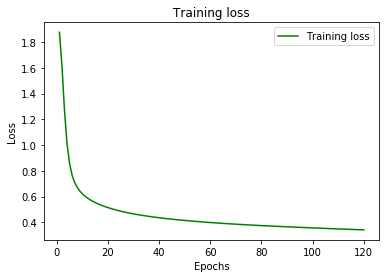

In [14]:
#Your code here; plot the loss vs the number of epoch

history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the alternative perspective, we can also plot the successive accuracy of our model as the model is tuned:

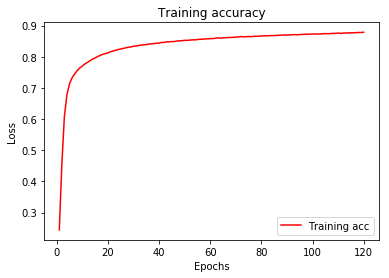

In [15]:
#Your code here; plot the training accuracy vs the number of epochs

acc_values = history_dict['acc'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It seems like we could just keep on going and accuracy would go up!

## Make predictions

Finally, it's time to output. Use the method discussed in the previous lesson to output (probability) predictions for the test set.

In [16]:
y_hat_test = model.predict(test) #Your code here; Output (probability) predictions for the test set.

## Evaluate Performance

Finally, print the loss and accuracy for both the train and test sets of the final trained model.

In [17]:
#Your code here; print the loss and accuracy for the training set.
results_train = model.evaluate(train, label_train)
results_train

58500/58500 [==============================] - 1s 20us/step


[0.3385159788148271, 0.8770256410256411]

In [18]:
#Your code here; print the loss and accuracy for the test set.
results_test = model.evaluate(test, label_test)
results_test

1500/1500 [==============================] - 0s 25us/step


[0.2747621349096298, 0.9200000001589457]

We can see that the training set results are really good (a 89.4% classification accuracy!), but the test set results lag behind. In the next lab. We'll talk a little more about this in the next lecture, and will discuss how we can get better test set results as well!

## Additional Resources

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

https://catalog.data.gov/dataset/consumer-complaint-database

## Summary 

Congratulations! In this lab, you built a neural network with much less production time thanks to the tools provided by Keras! In upcoming lessons and labs we'll continue to investigate further ideas regarding how to tune and refine these models for increased accuracy and performance.